In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Make tables easier to read
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

CSV_PATH = "clean_data.csv"

In [2]:
N_ROWS = None
df = pd.read_csv(CSV_PATH, nrows=N_ROWS)
df.head()

,any,mes,codi de la regió sanitària,regió sanitària,grup d'edat,sexe,codi del grup ATC nivell 1,grup ATC nivell 1,codi del grup ATC nivell 2,grup ATC nivell 2,codi del grup ATC nivell 3,grup ATC nivell 3,codi del grup ATC nivell 4,grup ATC nivell 4,nombre de receptes,nombre d'envasos,import íntegre,import aportació CatSalut
0,2025,9,61,LLEIDA,0-1 any,Dona,A,TRACTO ALIMENTARIO Y METABOLISMO,A01,PREPARADOS ESTOMATOLOGICOS,A01A,PREPARADOS ESTOMATOLOGICOS,A01AB,Antiinfecciosos y antisepticos para el tratami...,3.0,3.0,"8,49","7,36"
1,2025,9,61,LLEIDA,0-1 any,Dona,A,TRACTO ALIMENTARIO Y METABOLISMO,A02,AGENTES PARA EL TRATAMIENTO DE ALTERACIONES CA...,A02B,AGENTES CONTRA LA ULCERA PEPTICA Y EL REFLUJO ...,A02BC,Inhibidores de la bomba de protones,1.0,1.0,"17,75","10,65"
2,2025,9,61,LLEIDA,0-1 any,Dona,A,TRACTO ALIMENTARIO Y METABOLISMO,A07,"ANTIDIARREICOS, AGENTES ANTIINFLAMATORIOS/ANTI...",A07A,ANTIINFECCIOSOS INTESTINALES,A07AA,Antibioticos,17.0,17.0,"79,56","53,84"
3,2025,9,61,LLEIDA,0-1 any,Dona,A,TRACTO ALIMENTARIO Y METABOLISMO,A07,"ANTIDIARREICOS, AGENTES ANTIINFLAMATORIOS/ANTI...",A07C,ELECTROLITOS CON CARBOHIDRATOS,A07CA,Formulaciones de sales de rehidratacion oral,27.0,27.0,"95,62","56,26"
4,2025,9,61,LLEIDA,0-1 any,Dona,A,TRACTO ALIMENTARIO Y METABOLISMO,A11,VITAMINAS,A11C,"VITAMINAS A Y D, INCLUYENDO COMBINACIONES DE L...",A11CC,Vitamina D y analogos,307.0,307.0,"1.708,00","1.036,48"


# Time Series

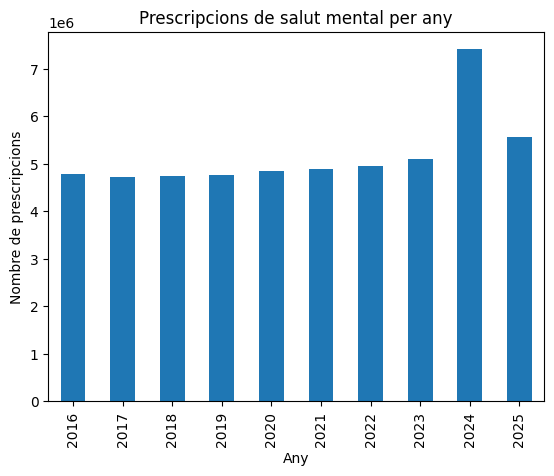

In [3]:
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS",
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA EL TDAH Y NOOTROPICOS",
    "PSICOESTIMULANTES, AGENTES UTILIZADOS PARA LA ADHD Y NOOTROPICOS",
    "OTROS FARMACOS QUE ACTUAN SOBRE EL SISTEMA NERVIOSO"
]

mh = df[df["grup ATC nivell 3"].isin(mental_groups)]


mh.groupby("any")["nombre de receptes"].sum().plot(kind="bar")
plt.xlabel("Any")
plt.ylabel("Nombre de prescripcions")
plt.title("Prescripcions de salut mental per any")
plt.show()

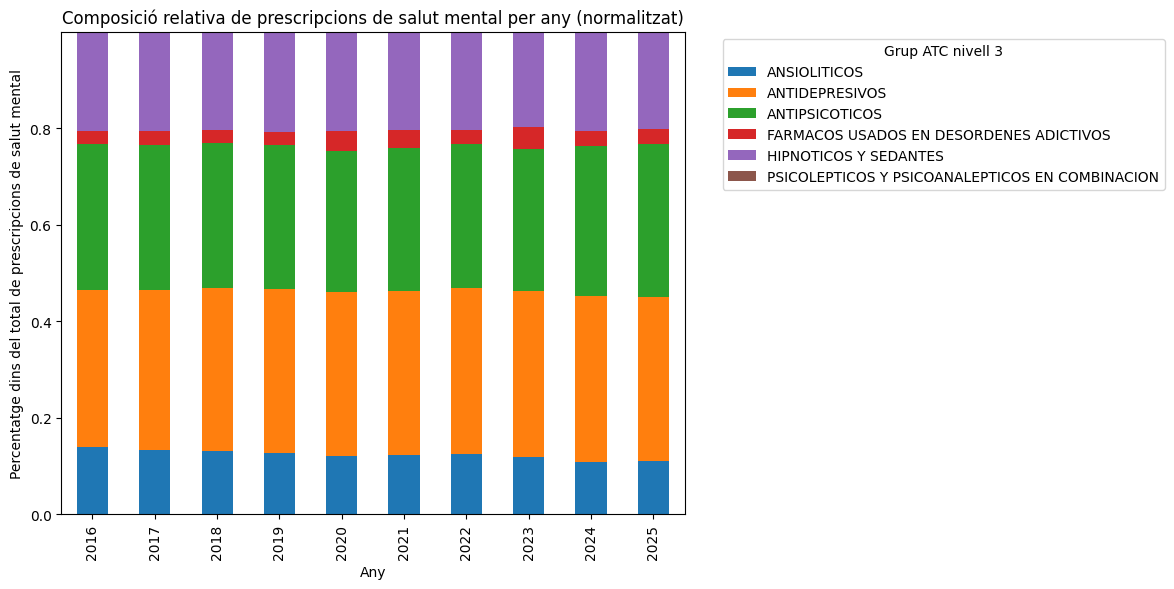

In [4]:
mental_groups = [
    "ANTIDEPRESIVOS",
    "ANSIOLITICOS",
    "ANTIPSICOTICOS",
    "HIPNOTICOS Y SEDANTES",
    "FARMACOS USADOS EN DESORDENES ADICTIVOS",
    "PSICOLEPTICOS Y PSICOANALEPTICOS EN COMBINACION"
]

# Filter to mental-health prescriptions
mh = df[df["grup ATC nivell 3"].isin(mental_groups)]

# Group by year and drug group
mh_grouped = mh.groupby(["any", "grup ATC nivell 3"])["nombre de receptes"].sum()

# Convert to wide format
mh_wide = mh_grouped.unstack(fill_value=0)

# Normalize each year to sum = 1
mh_norm = mh_wide.div(mh_wide.sum(axis=1), axis=0)

# Plot normalized stacked chart
mh_norm.plot(kind="bar", stacked=True, figsize=(12,6))
plt.xlabel("Any")
plt.ylabel("Percentatge dins del total de prescripcions de salut mental")
plt.title("Composició relativa de prescripcions de salut mental per any (normalitzat)")
plt.legend(title="Grup ATC nivell 3", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\gerar\AppData\Local\Temp\ipykernel_10160\2316527552.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mh["date"] = pd.to_datetime(


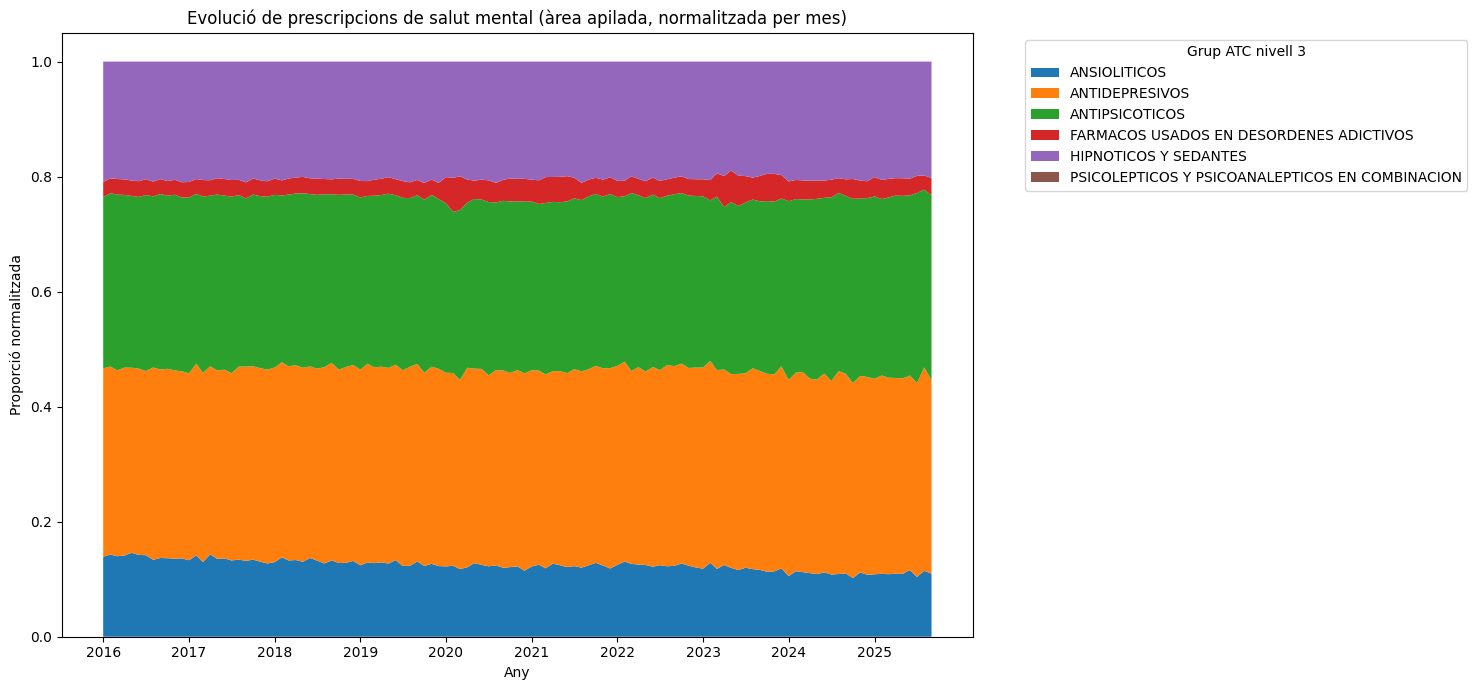

In [5]:
mh = df[df["grup ATC nivell 3"].isin(mental_groups)]

# Build a proper datetime for monthly data
mh["date"] = pd.to_datetime(
    mh["any"].astype(str) + "-" + mh["mes"].astype(str) + "-01"
)

# Group by date and category
grouped = (
    mh.groupby(["date", "grup ATC nivell 3"])["nombre de receptes"]
      .sum()
      .reset_index()
)

# Normalize per month
total_month = (
    grouped.groupby("date")["nombre de receptes"]
           .sum()
           .rename("total_mes")
)
grouped = grouped.merge(total_month, on="date")
grouped["pct"] = grouped["nombre de receptes"] / grouped["total_mes"]

# Pivot so each group is its own column
pivot = grouped.pivot(
    index="date",
    columns="grup ATC nivell 3",
    values="pct"
).fillna(0)

plt.figure(figsize=(15, 7))

# Stacked area plot
plt.stackplot(
    pivot.index,
    pivot.T.values,
    labels=pivot.columns,
)

# X-axis: show only years
year_ticks = pd.date_range(
    start=pivot.index.min(),
    end=pivot.index.max(),
    freq="YS"
)
plt.xticks(
    ticks=year_ticks,
    labels=[str(y.year) for y in year_ticks]
)

plt.xlabel("Any")
plt.ylabel("Proporció normalitzada")
plt.title("Evolució de prescripcions de salut mental (àrea apilada, normalitzada per mes)")
plt.legend(title="Grup ATC nivell 3", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# By Regions

<Axes: xlabel='regió sanitària,regió sanitària,grup ATC nivell 1'>

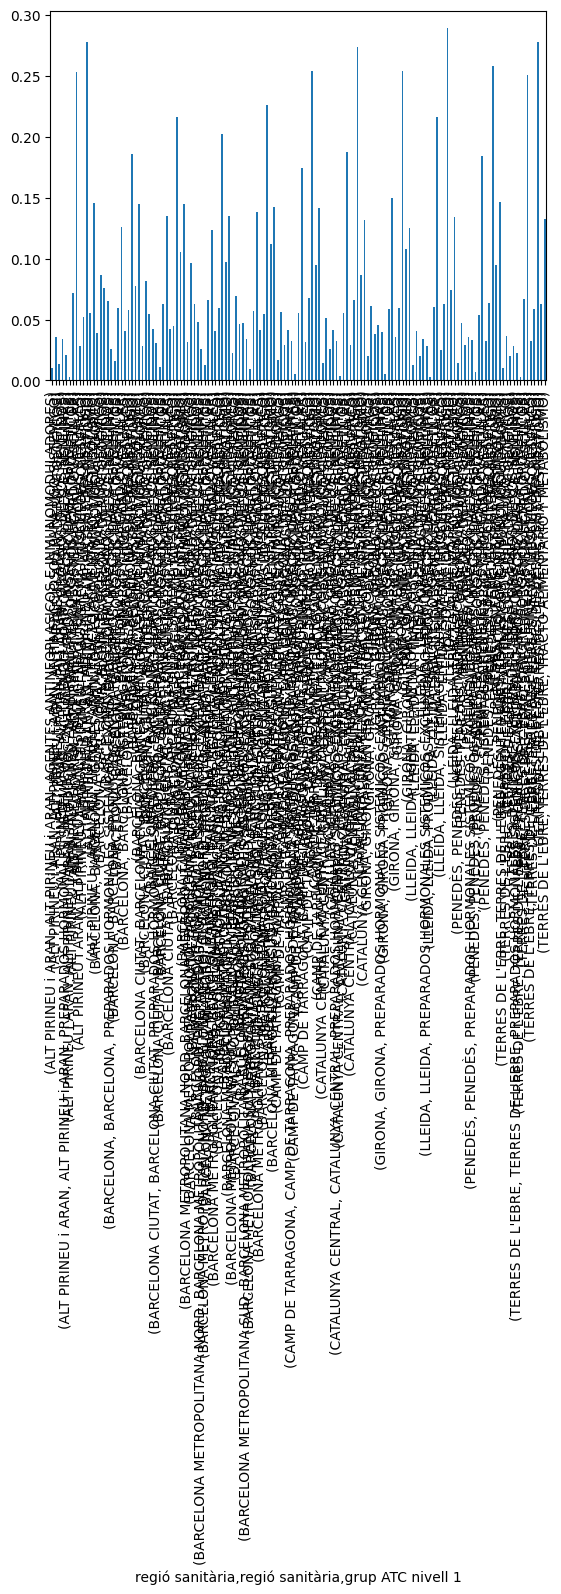

In [28]:
group_df = df.groupby(["regió sanitària", "grup ATC nivell 1"])["nombre de receptes"].sum()

proportions = group_df.groupby("regió sanitària").apply(lambda x: x / x.sum())

proportions.plot(kind="bar", stacked=True)

<Figure size 1400x700 with 0 Axes>

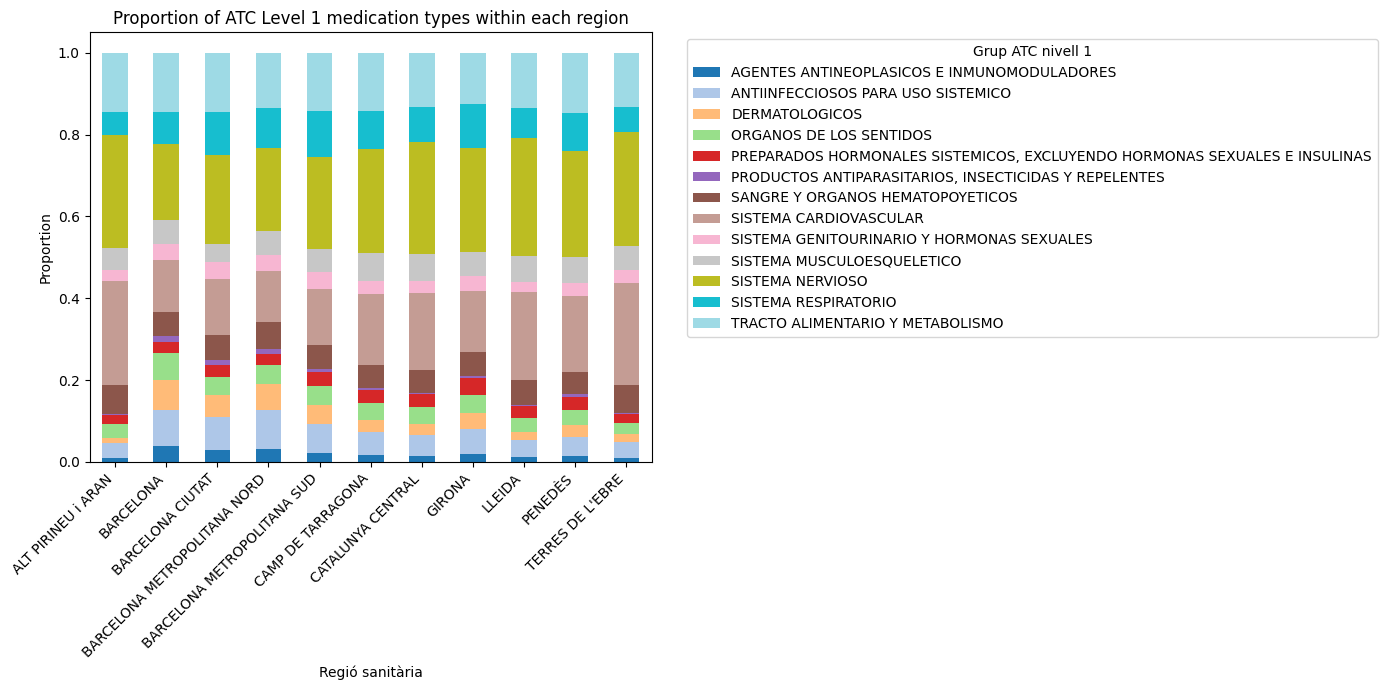

grup ATC nivell 1,AGENTES ANTINEOPLASICOS E INMUNOMODULADORES,ANTIINFECCIOSOS PARA USO SISTEMICO,DERMATOLOGICOS,ORGANOS DE LOS SENTIDOS,"PREPARADOS HORMONALES SISTEMICOS, EXCLUYENDO HORMONAS SEXUALES E INSULINAS","PRODUCTOS ANTIPARASITARIOS, INSECTICIDAS Y REPELENTES",SANGRE Y ORGANOS HEMATOPOYETICOS,SISTEMA CARDIOVASCULAR,SISTEMA GENITOURINARIO Y HORMONAS SEXUALES,SISTEMA MUSCULOESQUELETICO,SISTEMA NERVIOSO,SISTEMA RESPIRATORIO,TRACTO ALIMENTARIO Y METABOLISMO
regió sanitària,,,,,,,,,,,,,
ALT PIRINEU i ARAN,0.010323,0.035474,0.013751,0.033910,0.021093,0.002700,0.071405,0.252925,0.028606,0.051954,0.277541,0.054986,0.145330
BARCELONA,0.039145,0.086535,0.075496,0.064874,0.025894,0.016161,0.059254,0.125576,0.040688,0.057738,0.185940,0.077920,0.144778
BARCELONA CIUTAT,0.028213,0.081884,0.054361,0.042226,0.030390,0.011309,0.062953,0.135168,0.042576,0.044358,0.216277,0.105339,0.144946
BARCELONA METROPOLITANA NORD,0.031164,0.096305,0.062378,0.047594,0.025972,0.012484,0.066427,0.123385,0.040241,0.059502,0.202434,0.096975,0.135141
BARCELONA METROPOLITANA SUD,0.022802,0.069037,0.046062,0.047280,0.033712,0.009230,0.057174,0.138327,0.041126,0.054573,0.226362,0.112006,0.142309


In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1) GROUP BY REGION × ATC LEVEL 1 AND SUM PRESCRIPTIONS
# -------------------------------------------------------

counts = (
    df.groupby(["regió sanitària", "grup ATC nivell 1"])["nombre de receptes"]
      .sum()
)

# -------------------------------------------------------
# 2) GET PROPORTIONS OF ATC GROUPS *WITHIN EACH REGION*
# -------------------------------------------------------

proportions = counts.groupby(level=0).apply(lambda x: x / x.sum())

# -------------------------------------------------------
# 3) FIX DUPLICATED INDEX LEVEL (DROP SECOND LEVEL)
# -------------------------------------------------------

if proportions.index.nlevels > 1:
    proportions.index = proportions.index.droplevel(1)

# -------------------------------------------------------
# 4) PIVOT: rows = regions, columns = ATC groups
# -------------------------------------------------------

prop_table = proportions.unstack(fill_value=0)

# -------------------------------------------------------
# 5) PLOT (STACKED, PROPORTIONAL)
# -------------------------------------------------------

plt.figure(figsize=(14, 7))

ax = prop_table.plot(
    kind="bar",
    stacked=True,
    colormap="tab20",
    figsize=(14, 7)
)

plt.ylabel("Proportion")
plt.xlabel("Regió sanitària")
plt.title("Proportion of ATC Level 1 medication types within each region")

# Rotate x-axis labels (cleaner view)
plt.xticks(rotation=45, ha="right")

plt.legend(
    title="Grup ATC nivell 1",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

# View first rows of the table if needed
prop_table.head()
